In [ ]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Datele de intrare
k = np.array([10, 15, 20, 5, 25, 12, 18])  # utilizatorii care finalizeaza achizitia
n = np.array([100, 120, 150, 90, 200, 110, 130])  # vizitatorii zilnici

with pm.Model() as model:
    # Distributie prior pentru ratele zilnice (p1,..., p7)
    p = pm.Beta("p", alpha=2, beta=2, shape=7)

    # Distributia binomiala pentru fiecare zi
    k_obs = pm.Binomial("k_obs", n=n, p=p, observed=k)

    # Rata medie a saptamanii
    p_mean = pm.Deterministic("p_mean", pm.math.mean(p))

In [ ]:
with model:
    # pm.sample creeaza esantioane aleatorii din distributia a posteriori a parametrilor modelului
    trace = pm.sample(2000, tune=1000, return_inferencedata=True)

Output()

Output()

In [ ]:
import arviz as az

         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
p[0]    0.116  0.031   0.062    0.176        0.0      0.0    5316.0    3104.0   
p[1]    0.137  0.031   0.081    0.194        0.0      0.0    6824.0    3189.0   
p[2]    0.142  0.028   0.089    0.194        0.0      0.0    4734.0    2974.0   
p[3]    0.074  0.026   0.027    0.121        0.0      0.0    6237.0    3045.0   
p[4]    0.133  0.023   0.091    0.178        0.0      0.0    4307.0    3190.0   
p[5]    0.123  0.031   0.066    0.180        0.0      0.0    4079.0    3090.0   
p[6]    0.149  0.031   0.094    0.208        0.0      0.0    4569.0    3026.0   
p_mean  0.125  0.011   0.105    0.145        0.0      0.0    4649.0    2813.0   

        r_hat  
p[0]      1.0  
p[1]      1.0  
p[2]      1.0  
p[3]      1.0  
p[4]      1.0  
p[5]      1.0  
p[6]      1.0  
p_mean    1.0  


array([[<Axes: title={'center': 'p\n0'}>,
        <Axes: title={'center': 'p\n1'}>,
        <Axes: title={'center': 'p\n2'}>,
        <Axes: title={'center': 'p\n3'}>],
       [<Axes: title={'center': 'p\n4'}>,
        <Axes: title={'center': 'p\n5'}>,
        <Axes: title={'center': 'p\n6'}>,
        <Axes: title={'center': 'p_mean'}>]], dtype=object)

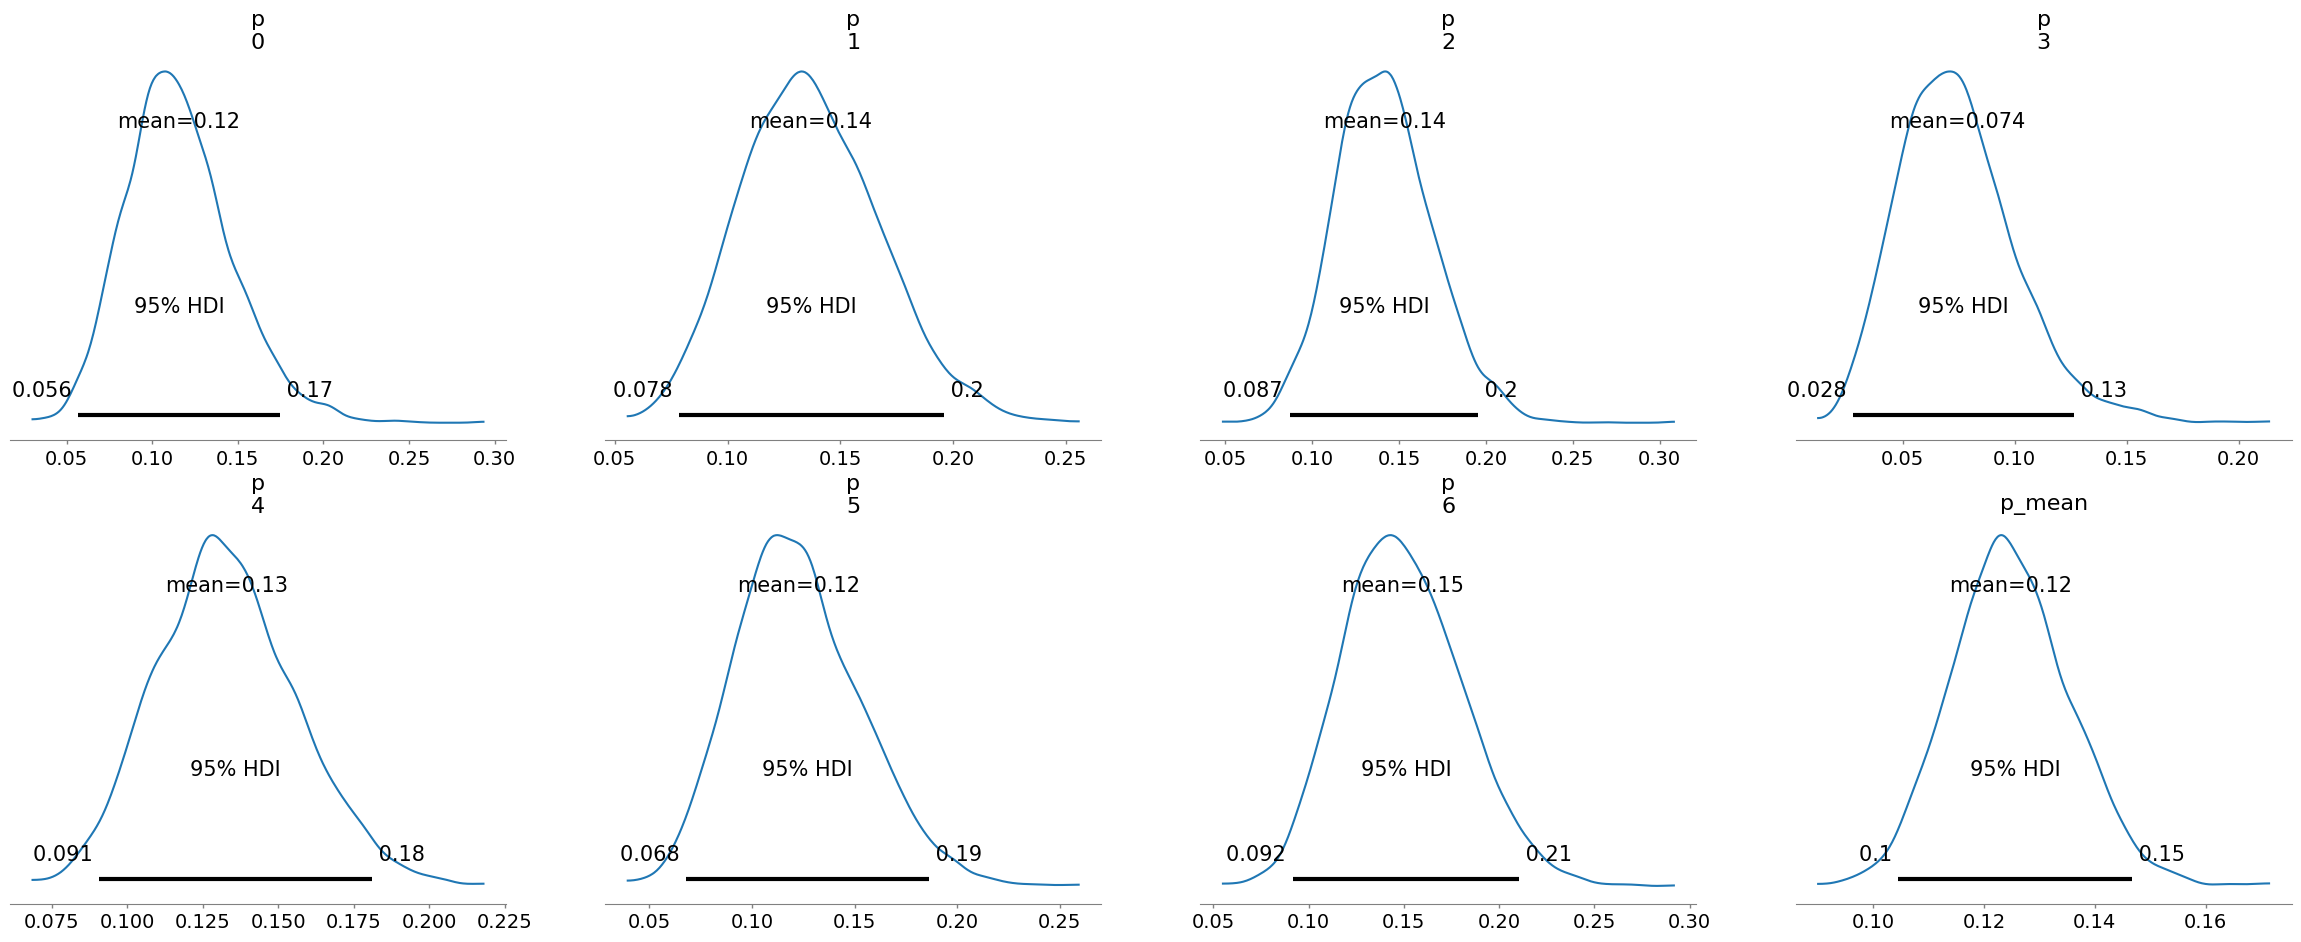

In [ ]:
# Afisare sumar a posteriori (proprietatile distributiei)
print(az.summary(trace, var_names=["p", "p_mean"]))

# Vizualizare a distributiei a posteriori pentru fiecare p_i și pentru rata medie
az.plot_posterior(trace, var_names=["p", "p_mean"], hdi_prob=0.95)

In [ ]:
import pandas as pd

In [ ]:
# Definirea intervalelor de timp
intervale = [
    (0, 180),  # 04:00 - 07:00 (interval 1)
    (180, 240),  # 07:00 - 08:00 (interval 2)
    (240, 960),  # 08:00 - 16:00 (interval 3)
    (960, 1140),  # 16:00 - 19:00 (interval 4)
    (1140, 1440)  # 19:00 - 24:00 (interval 5)
]

# Nummarul de minute din fiecare interval
interval_lengths = [end - start for start, end in intervale]

# Generez datele de trafic dintr-o distribuție Poisson
np.random.seed(42)  # Setăm un seed pentru reproducibilitate

# Simulez valorile λ pentru fiecare interval
lambda_simulate = np.random.gamma(shape=1, scale=10, size=5)
trafic_simulat = [np.random.poisson(lam=l, size=length) for l, length in zip(lambda_simulate, interval_lengths)]

In [ ]:
# Cream modelul probabilistic în PyMC
with pm.Model() as model:
    # Priori pentru λ în fiecare interval (Gamma)
    lambda_vals = pm.Gamma("lambda_vals", alpha=1, beta=1, shape=5)

    # Model Poisson pentru fiecare interval
    # Am calculat care e distributia acelor intervale presupunand ca e modelat de o distributie poisson
    for i, (trafic_interval, (start, end)) in enumerate(zip(trafic_simulat, intervale)):
        # Observații Poisson pentru intervalul i
        pm.Poisson(f"trafic_{i}", mu=lambda_vals[i], observed=trafic_interval)

    # Sampling pentru obținerea valorilor a posteriori
    # Imbunatates valorile λ pe baza sample-urilor
    trace = pm.sample(1000, tune=500, random_seed=42)

Output()

Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lambda_vals[0],4.472,0.163,4.195,4.795,0.003,0.002,2838.0,1782.0,1.0
lambda_vals[1],29.869,0.693,28.573,31.148,0.013,0.009,2897.0,1604.0,1.0
lambda_vals[2],13.201,0.131,12.955,13.444,0.003,0.002,2532.0,1734.0,1.0
lambda_vals[3],8.838,0.220,8.422,9.243,0.004,0.003,3155.0,1836.0,1.0
lambda_vals[4],1.715,0.075,1.580,1.860,0.002,0.001,2323.0,1506.0,1.0


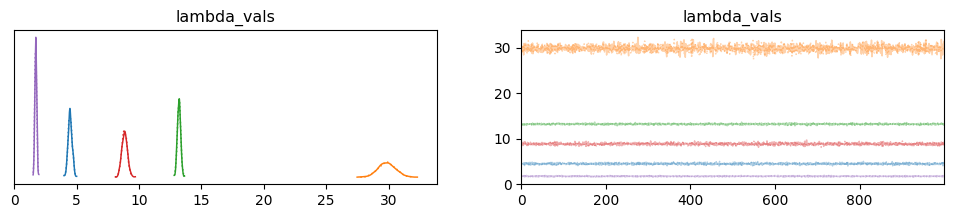

In [ ]:
# Vizualizarea rezultatelor a posteriori pentru λ - valorile lor medii
import arviz as az
az.plot_trace(trace, var_names=["lambda_vals"])
az.summary(trace, var_names=["lambda_vals"])

In [ ]:
# Extragem valorile medii ale λ pentru fiecare interval
lambda_intervale = np.mean(trace.posterior["lambda_vals"].values, axis=0)
print("Valorile medii ale λ pentru fiecare interval:", lambda_intervale)

Valorile medii ale λ pentru fiecare interval: [[ 4.34624328 30.3136338  13.08262626  8.81273788  1.68992421]
 [ 4.57674739 29.32771752 13.14290469  8.97069427  1.68923971]
 [ 4.45065704 29.71922362 13.17311083  8.69552652  1.76853442]
 ...
 [ 4.34996468 29.93112423 13.32726604  8.56059935  1.77728647]
 [ 4.59478863 29.90161361 13.06984032  9.07930696  1.69525618]
 [ 4.62550721 30.54744878 13.03646115  8.6673512   1.6965412 ]]


In [ ]:
# Calculez intervalele de credibilitate 95% pentru pentru valorile a posteriori ale lui λ
credibilitate_intervale = az.hdi(trace, var_names=["lambda_vals"], hdi_prob=0.95)

# Afisez intervalele de credibilitate pentru λ
print("Intervalele de credibilitate 95% pentru λ:")
for i, interval in enumerate(credibilitate_intervale["lambda_vals"]):
    print(f"Intervalul {i+1} (λ): {interval}")

Intervalele de credibilitate 95% pentru λ:
Intervalul 1 (λ): <xarray.DataArray 'lambda_vals' (hdi: 2)>
array([4.17044444, 4.79626085])
Coordinates:
    lambda_vals_dim_0  int64 0
  * hdi                (hdi) <U6 'lower' 'higher'
Intervalul 2 (λ): <xarray.DataArray 'lambda_vals' (hdi: 2)>
array([28.58554529, 31.26956472])
Coordinates:
    lambda_vals_dim_0  int64 1
  * hdi                (hdi) <U6 'lower' 'higher'
Intervalul 3 (λ): <xarray.DataArray 'lambda_vals' (hdi: 2)>
array([12.93406384, 13.44351304])
Coordinates:
    lambda_vals_dim_0  int64 2
  * hdi                (hdi) <U6 'lower' 'higher'
Intervalul 4 (λ): <xarray.DataArray 'lambda_vals' (hdi: 2)>
array([8.42183467, 9.28144776])
Coordinates:
    lambda_vals_dim_0  int64 3
  * hdi                (hdi) <U6 'lower' 'higher'
Intervalul 5 (λ): <xarray.DataArray 'lambda_vals' (hdi: 2)>
array([1.5693205 , 1.85986122])
Coordinates:
    lambda_vals_dim_0  int64 4
  * hdi                (hdi) <U6 'lower' 'higher'
